# Glide Performance

- How often does Glide sample a native pose?
- How often does Glide correctly score a native pose?

In [25]:
import sys
import os
import numpy as np

import matplotlib.pyplot as plt
sys.path.append('../1_dock')
from shared_paths import shared_paths
sys.path.append('../3_analyze')
from containers import LigandManager, Dataset

%matplotlib inline

# Load docking data

In [26]:
prots = [fname for fname in os.listdir(shared_paths['data']) if fname[0] != '.']
prots

['O60885',
 'GCR',
 'BRAF',
 'DTRANSP',
 'P00749',
 'SMO',
 'P03951',
 'AR',
 'MEK1',
 '5HT2B',
 'P00760',
 'CDK2',
 'SIGMA1',
 'JAK2',
 'ERA',
 'P18031',
 'P00489',
 'A2AR',
 'PLK1',
 'VITD',
 'GLUT1',
 'MGLUR5',
 'STRANSP',
 'B2AR',
 'TRPV1',
 'Q9Y233',
 'P00734',
 'MR',
 'M3',
 'Q16539',
 'P00742',
 'P56817',
 'P07900',
 'P24941',
 'B1AR',
 'CHK1']

In [27]:
data = Dataset(shared_paths, prots)

In [28]:
for prot in prots:
    lm = LigandManager(shared_paths, prot)
    data.load({prot: lm.pdb}, {prot: [lm.st]}, load_fp = False, load_mcss = False)

/scratch/PI/rondror/combind/bpp_data/BRAF/docking/glide12 3TV4_lig 1UWH
('/scratch/PI/rondror/combind/bpp_data/BRAF/docking/glide12/3TV4_lig-to-1UWH', '/scratch/PI/rondror/combind/bpp_data/BRAF/ifp/ifp3/3TV4_lig-to-1UWH.fp')
/scratch/PI/rondror/combind/bpp_data/ERA/docking/glide12 1L2I_lig 1A52
('/scratch/PI/rondror/combind/bpp_data/ERA/docking/glide12/1L2I_lig-to-1A52', '/scratch/PI/rondror/combind/bpp_data/ERA/ifp/ifp3/1L2I_lig-to-1A52.fp')
/scratch/PI/rondror/combind/bpp_data/Q16539/docking/glide12 3GCP_lig 1KV1
('/scratch/PI/rondror/combind/bpp_data/Q16539/docking/glide12/3GCP_lig-to-1KV1', '/scratch/PI/rondror/combind/bpp_data/Q16539/ifp/ifp3/3GCP_lig-to-1KV1.fp')


In [276]:
glide = {}
for prot_name, protein in data.proteins.items():
    struct = protein.lm.st
    docking = protein.docking[struct]
    prot_key = struct+'_'+prot_name
    glide[prot_key] = {}
    for lig_name, ligand in docking.ligands.items():
        glide[prot_key][lig_name] = np.array([map(lambda x: x.rmsd, ligand.poses),
                                              map(lambda x: x.gscore, ligand.poses)])
        if None in glide[prot_key][lig_name]:
            del glide[prot_key][lig_name]

In [277]:
for k, v in glide.items():
    print k, len(v)

1B38_P24941 18
2YEL_O60885 17
4M48_DTRANSP 9
5HK1_SIGMA1 2
1KV1_Q16539 20
1C5X_P00749 19
2RH1_B2AR 8
4IB4_5HT2B 2
4CR5_P03951 14
1A52_ERA 20
2OWB_PLK1 12
3UI7_Q9Y233 20
1S9J_MEK1 23
1EZQ_P00742 20
1NHZ_GCR 18
1A4W_P00734 20
5EQG_GLUT1 3
2VT4_B1AR 12
2B7A_JAK2 21
2A3I_MR 13
1A8I_P00489 21
1FKN_P56817 20
1NVQ_CHK1 20
1AQ1_CDK2 19
1BJU_P00760 18
1YC1_P07900 20
1DB1_VITD 20
2YDO_A2AR 18
5I6X_STRANSP 5
1E3G_AR 11
4DAJ_M3 2
4JKV_SMO 7
1UWH_BRAF 30
4OO9_MGLUR5 5
1BZC_P18031 20
5IRX_TRPV1 2


# How often does Glide sample a correct pose?

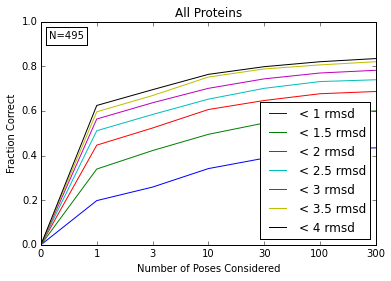

In [278]:
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText

def add_at(ax, t, loc=2):
    fp = dict(size=10)
    _at = AnchoredText(t, loc=loc, prop=fp)
    ax.add_artist(_at)
    return _at

def percentage_native(rmsds, poses = 1, thresh = 2.0):
    hit, total = 0.0, 0.0
    for rmsd in rmsds:
        if None in rmsd: continue
        hit   += any(rmsd[:poses] < thresh)
        total += 1
    return hit / total

rmsds = [rmsd[0] for prot, ligands in glide.items() for lig, rmsd in ligands.items()
         if lig.split('_')[0] != prot.split('_')[0]]

POSES = [0, 1, 3, 10, 30, 100, 300]

f, ax = plt.subplots()

for thresh in [1, 1.5, 2, 2.5, 3, 3.5, 4]:
    Y = [percentage_native(rmsds, poses, thresh)
         for poses in POSES]
    ax.plot(Y, label = "< {} rmsd".format(thresh))
ax.set_xticklabels(POSES)
ax.legend(loc = 4)
ax.set_ylabel('Fraction Correct')
ax.set_xlabel('Number of Poses Considered')
ax.set_title('All Proteins')
ax.set_ylim(0, 1)
add_at(ax, "N={}".format(len(rmsds)))

In [279]:
class Table:
    def __init__(self, columns):
        self.columns = columns
    
    def __call__(self, data):
        s = ''
        for width, d in zip(self.columns, data):
            d = str(d)[:width-1]
            s += str(d).ljust(width, ' ')
        print s

potential = Table([10]*4)
potential(['RMSD', 'top 1', 'top 100', 'Potential'])

rmsds = [rmsd[0] for prot, ligands in glide.items() for lig, rmsd in ligands.items()
         if lig.split('_')[0] != prot.split('_')[0]]
for thresh in [1, 1.5, 2, 2.5, 3, 3.5, 4, 8]:
    potential([thresh,
               percentage_native(rmsds, 1, thresh),
               percentage_native(rmsds, 100, thresh), 
               percentage_native(rmsds, 100, thresh) - percentage_native(rmsds, 1, thresh)
              ])

RMSD      top 1     top 100   Potential 
1         0.1979797 0.4282828 0.2303030 
1.5       0.3393939 0.5838383 0.2444444 
2         0.4464646 0.6767676 0.2303030 
2.5       0.5111111 0.7313131 0.2202020 
3         0.5636363 0.7696969 0.2060606 
3.5       0.5959595 0.8060606 0.2101010 
4         0.6242424 0.8202020 0.1959595 
8         0.8464646 0.9535353 0.1070707 


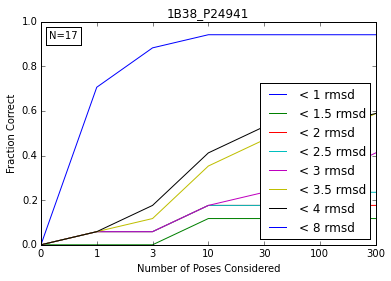

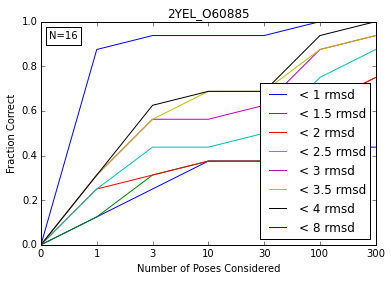

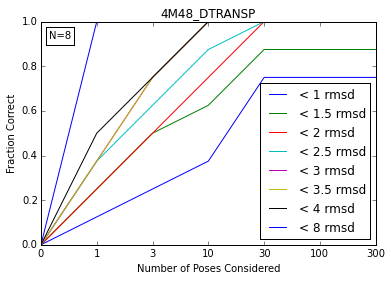

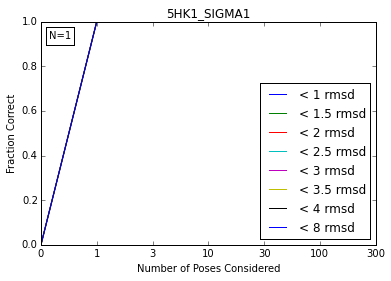

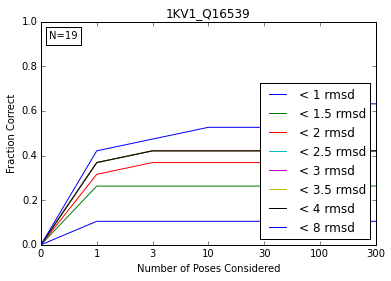

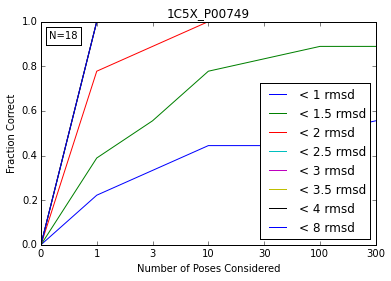

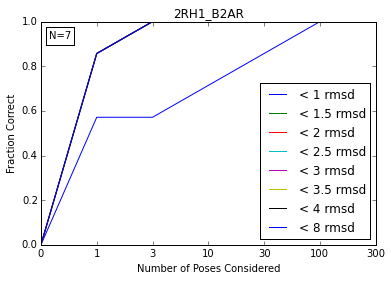

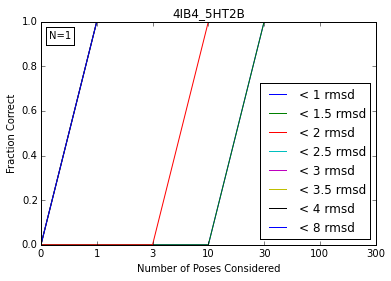

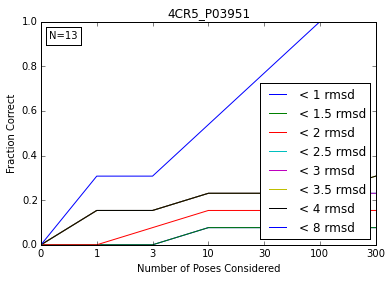

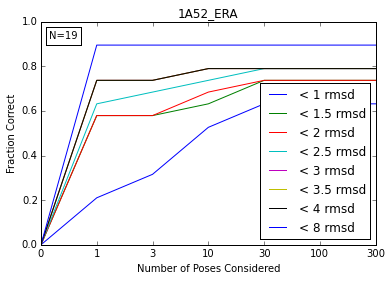

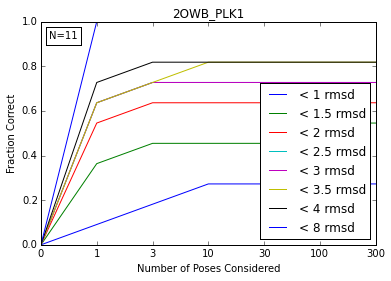

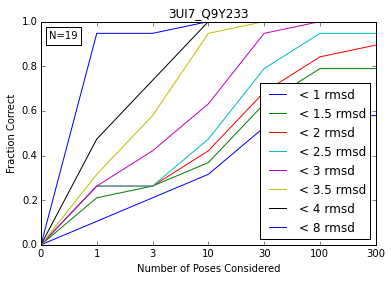

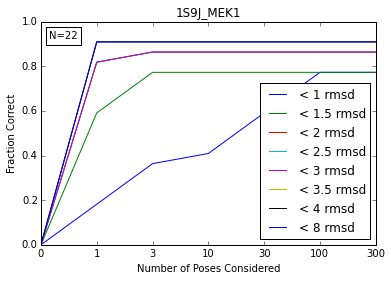

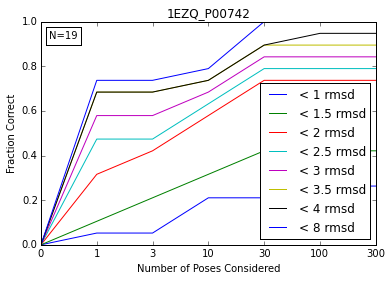

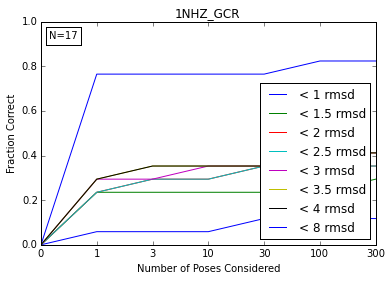

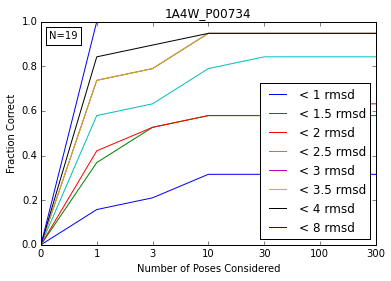

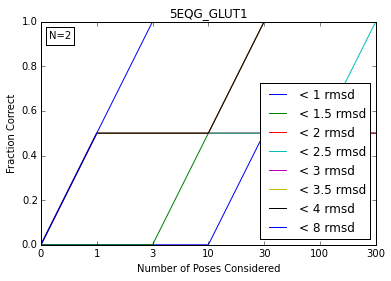

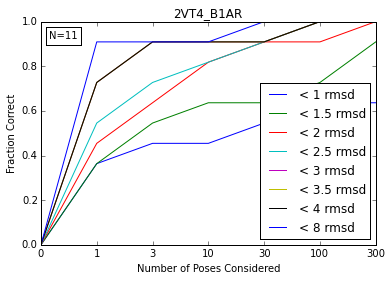

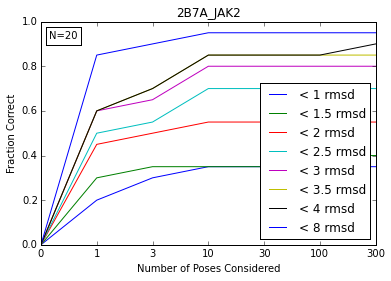

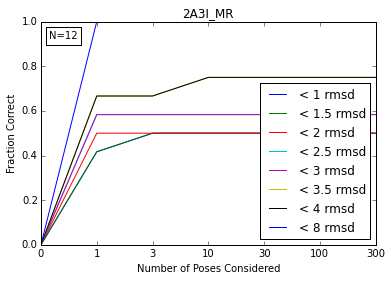

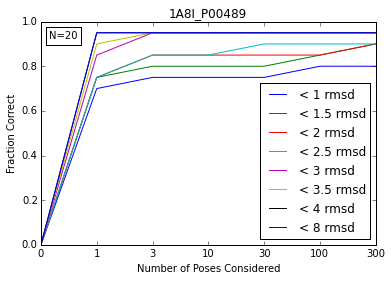

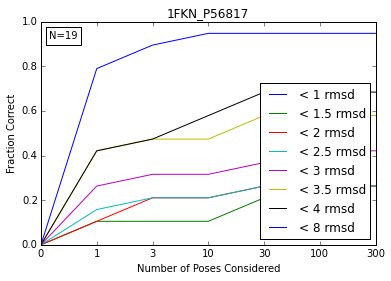

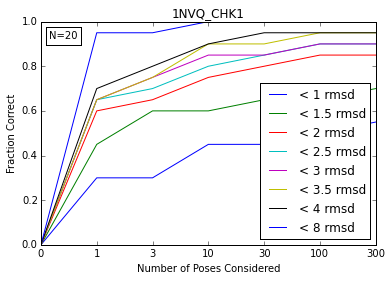

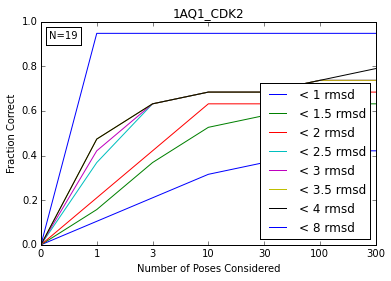

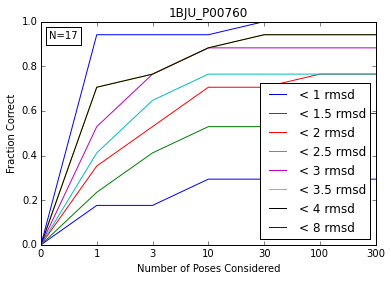

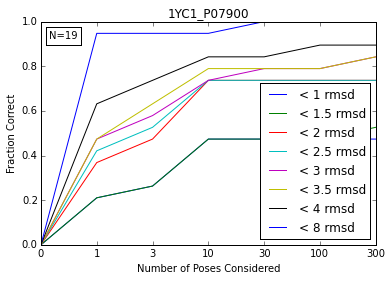

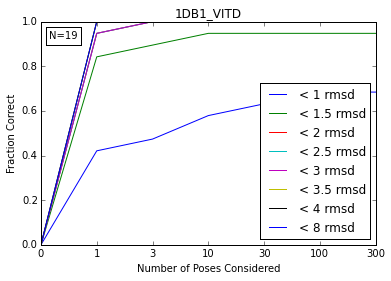

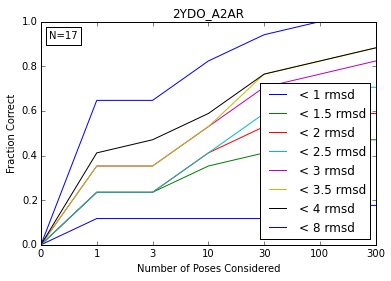

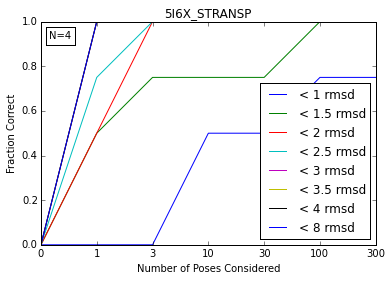

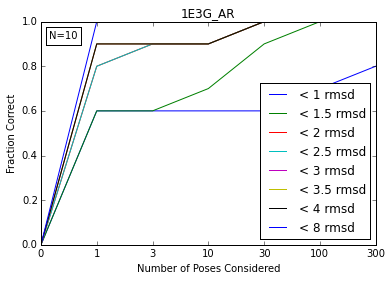

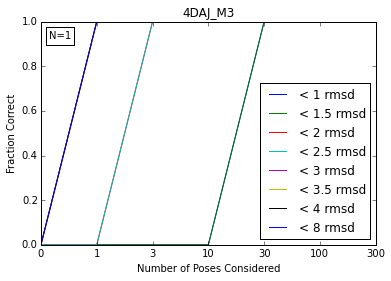

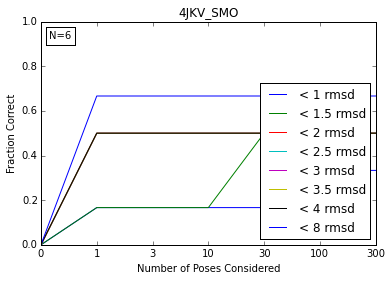

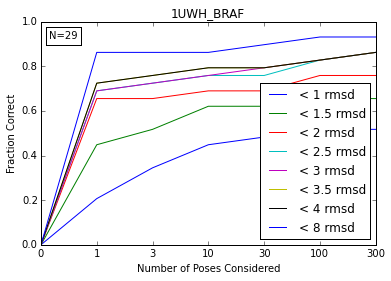

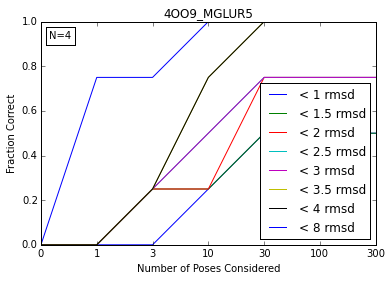

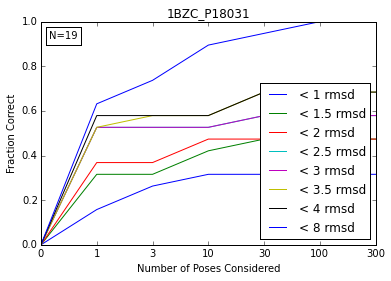

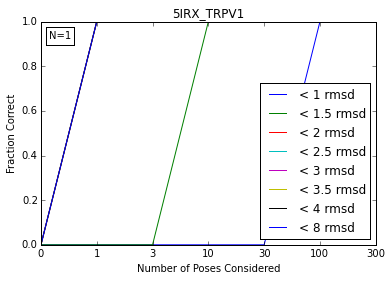

In [280]:
POSES = [0, 1, 3, 10, 30, 100, 300]

for prot, ligands in glide.items():
    rmsds = [rmsd[0] for lig, rmsd in ligands.items()
             if lig.split('_')[0] != prot.split('_')[0]]
    f, ax = plt.subplots()
    for thresh in [1, 1.5, 2, 2.5, 3, 3.5, 4, 8]:
        Y = [percentage_native(rmsds, poses, thresh)
             for poses in POSES]
        ax.plot(Y, label = "< {} rmsd".format(thresh))
    ax.set_xticklabels(POSES)
    ax.legend(loc = 4)
    ax.set_ylabel('Fraction Correct')
    ax.set_xlabel('Number of Poses Considered')
    ax.set_title(prot)
    ax.set_ylim(0, 1)
    add_at(ax, "N={}".format(len(rmsds)))
    plt.show()

In [282]:
thresh = 2.0

t = Table([15, 8, 8, 8])
t(['Protein', 'N', 'top 1', 'top 100'])

for prot, ligands in glide.items():
    rmsds = [rmsd[0] for lig, rmsd in ligands.items()
             if lig.split('_')[0] != prot.split('_')[0]]
    t([prot,
       len(rmsds),
       percentage_native(rmsds, 1, thresh),
       percentage_native(rmsds, 100, thresh)])

Protein        N       top 1   top 100 
1B38_P24941    17      0.05882 0.17647 
2YEL_O60885    16      0.25    0.625   
4M48_DTRANSP   8       0.25    1.0     
5HK1_SIGMA1    1       1.0     1.0     
1KV1_Q16539    19      0.31578 0.42105 
1C5X_P00749    18      0.77777 1.0     
2RH1_B2AR      7       0.85714 1.0     
4IB4_5HT2B     1       0.0     1.0     
4CR5_P03951    13      0.0     0.15384 
1A52_ERA       19      0.57894 0.73684 
2OWB_PLK1      11      0.54545 0.63636 
3UI7_Q9Y233    19      0.26315 0.84210 
1S9J_MEK1      22      0.81818 0.86363 
1EZQ_P00742    19      0.31578 0.73684 
1NHZ_GCR       17      0.23529 0.35294 
1A4W_P00734    19      0.42105 0.63157 
5EQG_GLUT1     2       0.5     0.5     
2VT4_B1AR      11      0.45454 0.90909 
2B7A_JAK2      20      0.45    0.55    
2A3I_MR        12      0.5     0.5     
1A8I_P00489    20      0.75    0.85    
1FKN_P56817    19      0.10526 0.26315 
1NVQ_CHK1      20      0.6     0.85    
1AQ1_CDK2      19      0.21052 0.68421 


# Self-docking

In [157]:
for prot in ['AR']:
    lm = LigandManager(shared_paths, prot)
    data.load({prot: lm.pdb}, {prot: lm.grids}, load_fp = False, load_mcss = False)

In [269]:
glide = {}
for prot_name, protein in data.proteins.items():
    glide[prot_name] = {}
    for struct, docking in protein.docking.items():
        lig_name = "{}_lig".format(struct)
        if lig_name not in docking.ligands: continue
        ligand = docking.ligands[lig_name]
        glide[prot_name][lig_name] = np.array(map(lambda x: x.rmsd, ligand.poses))

In [272]:
for k, v in glide.items():
    print k, len(v)

P00489 1
5HT2B 1
A2AR 1
PLK1 1
MGLUR5 1
ERA 1
M3 1
P07900 1
GLUT1 1
P18031 1
P56817 1
O60885 1
MEK1 1
JAK2 1
P00742 1
DTRANSP 1
SIGMA1 1
P00760 1
B2AR 1
GCR 1
P24941 1
STRANSP 1
VITD 1
P00734 1
SMO 1
Q9Y233 1
P03951 1
P00749 1
Q16539 1
CHK1 0
TRPV1 1
CDK2 0
AR 1
BRAF 1
MR 1
B1AR 1


In [271]:
glide

{'5HT2B': {'4IB4_lig': array([  0.66096979,   0.99521663,   0.94975658,   0.74564438,
           0.27982986,   0.93916913,   0.21099387,   1.06708005,
           0.41618485,   0.96639809,   0.9393582 ,   0.9022258 ,
           0.82769365,   0.74114603,   1.00653791,   0.71226495,
           0.61032588,   0.67427124,   0.6543025 ,   1.08877055,
           0.81243106,   1.99447385,   1.97388391,   4.36066573,
           2.47687632,   9.7763242 ,   2.06855141,   2.52367085,
           5.01846329,   3.64087522,   9.84813493,   2.36389081,
           3.2294533 ,   2.29609875,   2.93794322,  10.64212635,
          10.8981047 ,  13.33557322])},
 'A2AR': {'2YDO_lig': array([ 0.50851658,  0.88410721,  0.88281464,  0.88217108,  0.88259574,
          0.88800319,  0.88818343,  0.88113593,  0.49827611,  0.88629128,
          0.8749944 ,  0.53087899,  0.53086088,  0.46138746,  0.45011438,
          0.45093605,  0.45650214,  0.45178058,  0.44977335,  0.45765635,
          0.45360679,  0.45620837,  0.

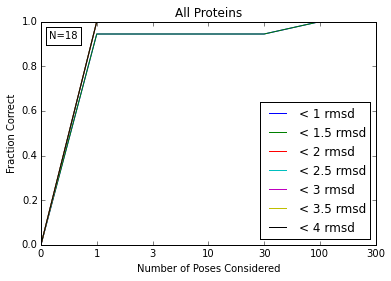

In [162]:
rmsds = [rmsd for prot, ligands in glide.items() for lig, rmsd in ligands.items() if prot == 'AR']

POSES = [0, 1, 3, 10, 30, 100, 300]

f, ax = plt.subplots()

for thresh in [1, 1.5, 2, 2.5, 3, 3.5, 4]:
    Y = [percentage_native(rmsds, poses, thresh)
         for poses in POSES]
    ax.plot(Y, label = "< {} rmsd".format(thresh))
ax.set_xticklabels(POSES)
ax.legend(loc = 4)
ax.set_ylabel('Fraction Correct')
ax.set_xlabel('Number of Poses Considered')
ax.set_title('All Proteins')
ax.set_ylim(0, 1)
add_at(ax, "N={}".format(len(rmsds)))
plt.show()

# Quantile-Quantile plot of glide scores and likelihood correct

In [338]:
glide = {}
for prot_name, protein in data.proteins.items():
    struct = protein.lm.st
    docking = protein.docking[struct]
    prot_key = struct+'_'+prot_name
    glide[prot_key] = {}
    for lig_name, ligand in docking.ligands.items():
        glide[prot_key][lig_name] = np.array([map(lambda x: x.rmsd, ligand.poses),
                                              map(lambda x: x.gscore, ligand.poses)])

In [339]:
rmsds = np.concatenate([rmsd[0] for prot, ligands in glide.items() for lig, rmsd in ligands.items()
                   if lig.split('_')[0] != prot.split('_')[0]])
gscores = np.concatenate([rmsd[1] for prot, ligands in glide.items() for lig, rmsd in ligands.items()
                     if lig.split('_')[0] != prot.split('_')[0]])

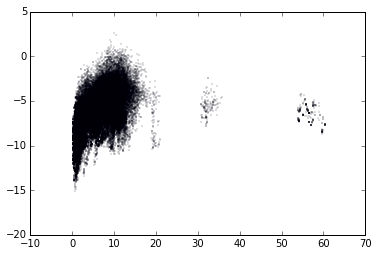

In [340]:
plt.scatter(rmsds, gscores, s=.1, alpha = 0.5)

In [341]:
scores = np.vstack([rmsd.T for prot, ligands in glide.items() for lig, rmsd in ligands.items()
                    if lig.split('_')[0] != prot.split('_')[0]])
scores = np.vstack(sorted(scores, key = lambda x: x[1]))
scores[:, 0] = scores[:, 0] < 2

In [342]:
quants = 100
bin_size = scores.shape[0] / quants
x, y = [], []
for i in range(0, scores.shape[0], bin_size):
    x += [scores[i:i+bin_size, 1].mean()]
    y += [np.log(scores[i:i+bin_size, 0].mean())]

/home/groups/rondror/software/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log


In [343]:
from sklearn.neighbors.kde import KernelDensity
kernel = KernelDensity(bandwidth = 0.01).fit(scores[:, 1].reshape(-1, 1))
density = np.exp(kernel.score_samples(np.array(x).reshape(-1, 1)))

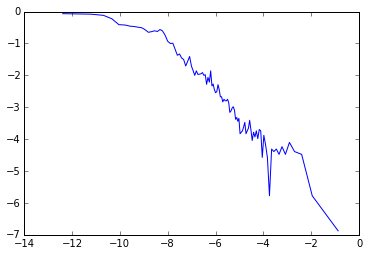

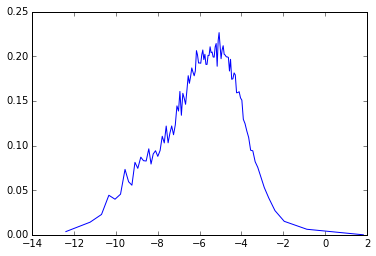

In [344]:
from scipy.stats import gaussian_kde 
plt.plot(x, y)
plt.show()
plt.plot(x, density)
plt.show()

In [345]:
scores = []
for prot, ligands in glide.items():
    for lig, rmsd in ligands.items():
        if None in rmsd: continue
        if lig.split('_')[0] != prot.split('_')[0] and rmsd.shape[1]:
            scores += [(rmsd - np.array([0, rmsd[1].min()]).reshape(2, 1)).T]

scores = np.vstack(scores)
scores = np.vstack(sorted(scores, key = lambda x: x[1]))
scores[:, 0] = scores[:, 0] < 2

In [353]:
quants = 500
bin_size = scores.shape[0] / quants
print bin_size
x, y = [], []
for i in range(0, scores.shape[0], bin_size):
    x += [scores[i:i+bin_size, 1].mean()]
    y += [np.log10(scores[i:i+bin_size, 0].mean())]

190


/home/groups/rondror/software/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


In [354]:
from sklearn.neighbors.kde import KernelDensity
kernel = KernelDensity(bandwidth = 0.1).fit(scores[:, 1].reshape(-1, 1))
density = np.exp(kernel.score_samples(np.array(x).reshape(-1, 1)))

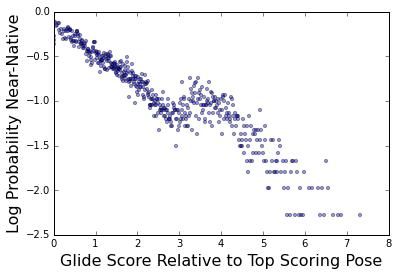

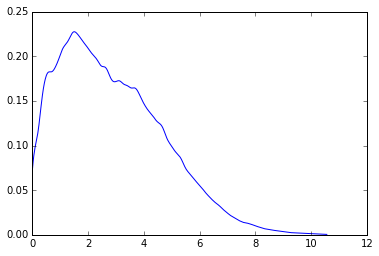

In [355]:
# from sklearn.linear_model import LinearRegression
# regress = LinearRegression().fit(np.array(x).reshape(-1, 1)[:-2], y[:-2])
# fit = regress.predict(np.array(x).reshape(-1, 1))

plt.scatter(x, y, s = 10, alpha = 0.4)
# plt.plot(x, fit)
plt.ylabel('Log Probability Near-Native', fontsize = 16)
plt.xlabel('Glide Score Relative to Top Scoring Pose', fontsize = 16)
plt.ylim(-2.5, 0)
plt.xlim(0, 8)
plt.show()
plt.plot(x, density)

In [337]:
print regress.coef_, regress.intercept_

[-0.26495031] -0.275633507733
